# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090B Data Science 2: Advanced Topics in Data Science 

## Lab 1 - Clustering

**Harvard University**<br>
**Spring 2025**<br>
**Instructors:** Pavlos Protopapas and Natesh Pillai<br>

In [7]:
from sklearn.datasets import make_blobs
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

### [Table of contents](#top)<a id='top'></a>
1. [KMeans Algorithm /w Numpy](#kmeans_numpy)
1. [Selecting $k$](#pick_k)
    - inertia
    - silhouette score
1. [KMeans /w SKLearn](#kmeans_sklearn)
1. Selecting $k$ (continued)
   - [gap statistic](#gap)
1. [DBSCAN](#dbscan)
    - motivation
    - selecting `min_samples` and `eps`

## KMeans from Scratch <a id='kmeans_numpy'></a>

[back to table of contents](#top)

We'll implement KMeans ourselves and use it to cluster a synthetic dataset produced with SKLearn's `make_blobs()`

In [8]:
n = 200 # number of data points
k = 4 # number of 'blobs'
X, y = make_blobs(n_samples=n, n_features=2, random_state=109, centers=k)

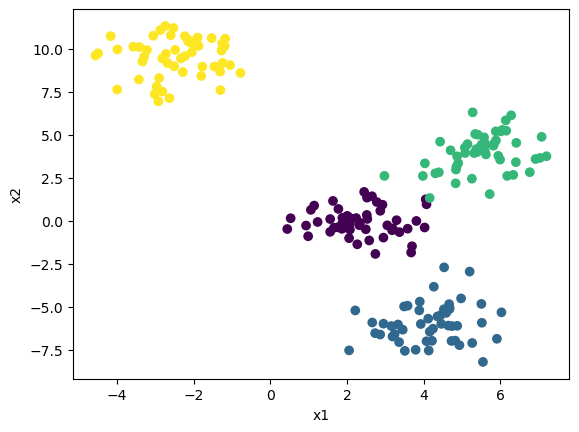

In [9]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel('x1')
plt.ylabel('x2');

In [10]:
# labels showing the 'blob' of origin
y

array([0, 3, 0, 1, 0, 3, 1, 3, 2, 2, 3, 0, 2, 3, 3, 2, 0, 3, 3, 3, 2, 1,
       2, 1, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 3, 0, 0, 3, 3, 3, 2, 3, 1, 0,
       0, 2, 0, 2, 2, 3, 0, 3, 2, 0, 0, 3, 1, 2, 3, 2, 2, 2, 3, 3, 1, 0,
       3, 1, 1, 0, 1, 2, 0, 3, 2, 3, 2, 3, 2, 1, 2, 0, 3, 2, 1, 3, 3, 0,
       3, 3, 0, 3, 3, 3, 3, 0, 2, 3, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 3, 3, 2, 1, 1, 1, 0, 1, 3, 2, 0, 0, 2, 0,
       2, 3, 1, 1, 3, 2, 3, 0, 1, 0, 2, 1, 3, 1, 2, 0, 3, 1, 2, 3, 1, 3,
       1, 3, 0, 0, 1, 2, 2, 0, 2, 0, 3, 1, 2, 0, 2, 2, 1, 3, 0, 2, 0, 2,
       0, 2, 0, 3, 1, 1, 1, 0, 2, 1, 0, 2, 3, 0, 1, 2, 3, 2, 1, 1, 1, 0,
       2, 1])

**Implementing KMeans**

In the interest of time we've provided our own implementation below. To test yourself you should try reimplementing the algorithm yourself without referencing the solution here.

**🤔 Q:** What are **2** simple ways we might initialize our centroids?\
**🤔 Q:** What are **3** different stopping conditions we might use for a run of the kmeans algorithm?

Hints for your own implementation:
* write helper functions for the core operations, even if they are one liners! It can help keep you organized
* Start with a single iteration, then wrap it in a loop for a full run, then wrap *that* in a loop to allow for multiple iterations

In [11]:
def init_centroids(X, k):
    # Sample observations to use as starting centroids
    return X[np.random.choice(X.shape[0], size=k, replace=False)]
    
def inertia(X, centroids, labels):
    # Calculate total inertia (which we want to minimize) across all clusters
    return sum([((X[labels==i]-centroids[i])**2).sum() for i in np.unique(labels)])

def get_labels(X, centroids):
    # Assign cluster labels to each data point based on distance to centroids
    return np.argmin(np.array([((X-c)**2).sum(axis=1) for c in centroids]), axis=0)

def get_centroids(X, labels):
    # Update centroids based on current cluster labels
    return np.array([X[labels==k_i].mean(axis=0) for k_i in np.unique(labels)]) 

In [12]:
def kmeans(X,
           k,
           n_init=15,
           tol=0.0001,
           max_iter=1_000,
           best_only=False,
           random_seed=109):
    # reproducible results (but best practice is to use np.random.default_rng())
    np.random.seed(random_seed) 

    # standardize features
    X = (X - X.mean(axis=0))/X.std(axis=0)
    
    # records labels and inertias from each init
    all_labels = np.zeros((X.shape[0], n_init), dtype=int)
    all_inertias = np.zeros(n_init)
    
    for i in range(n_init):
        ## init centroids by sampling random uniform of observed data range
        # centroids = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(k,2))
        # centroids = .random.uniform(X.min(axis=0), X.max(axis=0), size=(k,2))
        ## init centroids by selecting k random data points
        centroids = init_centroids(X, k)
        cur_iter = 0
        while (cur_iter := cur_iter+1):
            old_centroids = centroids.copy()
            labels = get_labels(X, centroids)
            centroids = get_centroids(X, labels) 
            # if cur_iter >= max_iter:
            if (centroids == old_centroids).all():
            # if ((centroids - old_centroids)**2).sum()**(1/2) < tol:
                all_labels[:,i] = labels
                all_inertias[i] = inertia(X, centroids, labels)
                break
    if best_only:
        return all_inertias.min()
    else:
        return all_labels, all_inertias

all_labels, all_inertias = kmeans(X, k)

Use the function below to plot the results of 15 initializations. You will need a list of labels from each initialization as well as the inertias from each initialization.

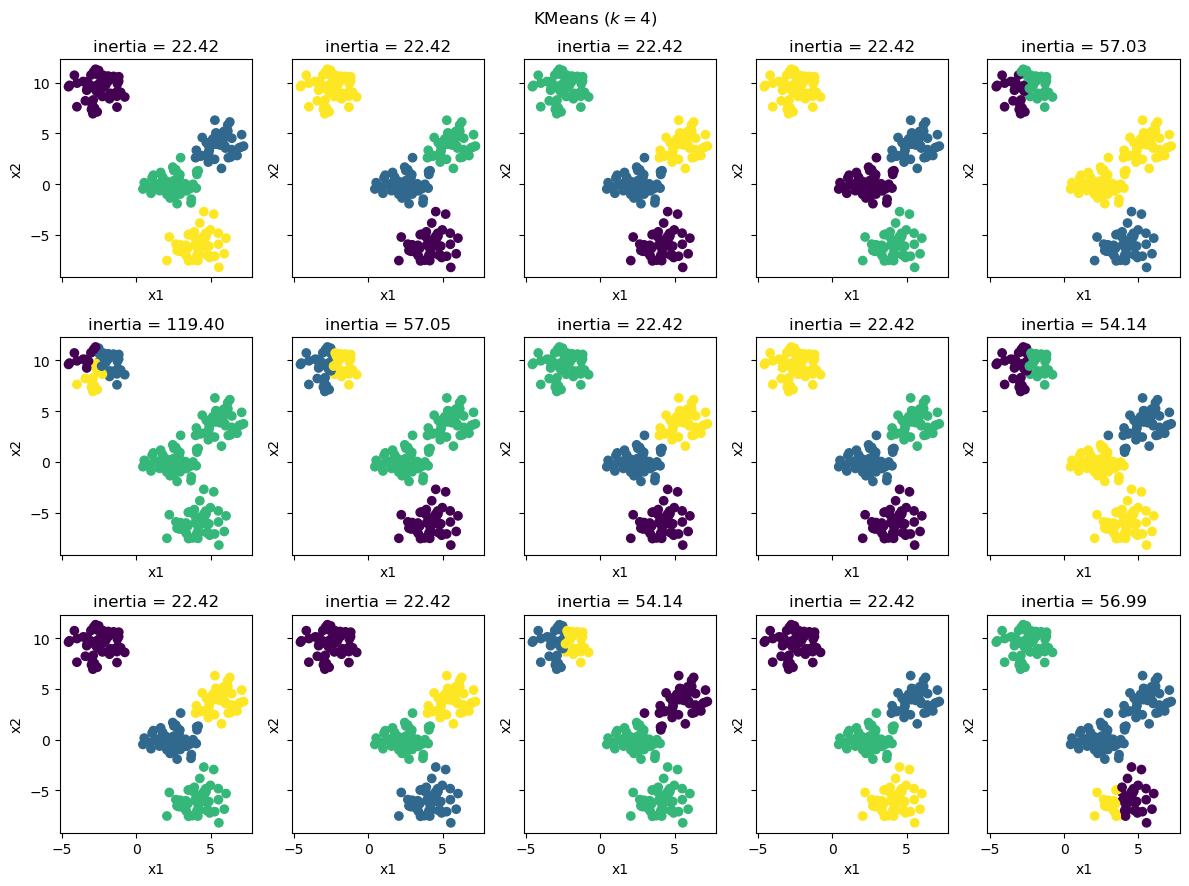

In [13]:
def plot_kmeans(X, all_labels, all_inertias):
    fig, axs = plt.subplots(3, 5, figsize=(12,9), sharex=True, sharey=True)
    for i, ax in enumerate(axs.ravel()):
        ax.scatter(X[:,0], X[:,1], c=all_labels[:,i])
        ax.set_title(f'inertia = {all_inertias[i]:.2f}')
        ax.set(xlabel='x1', ylabel='x2')
    plt.suptitle(f'KMeans ($k = {k}$)')
    plt.tight_layout()
    
plot_kmeans(X, all_labels, all_inertias)

Here's a plot showing the frequently each unique inertia value was achieved across the 15 initializations above.

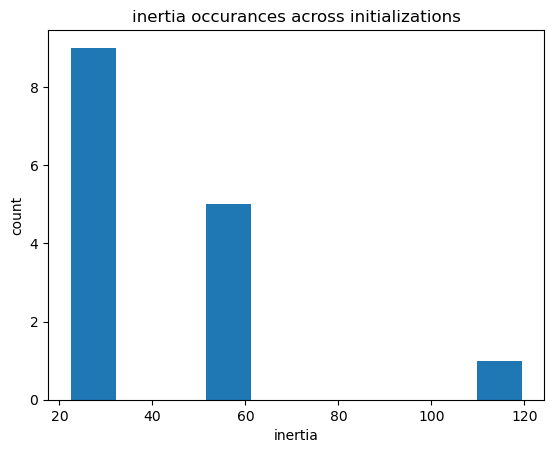

In [14]:
plt.hist(all_inertias)
plt.xlabel('inertia')
plt.ylabel('count')
plt.title('inertia occurances across initializations');

## Choosing $k$: Inertia <a id='pick_k'></a>

[back to table of contents](#top)

In the KMeans algorithm, $k$ is a **hyperparameter**. That is, the number of clusters is *not* learned from the data but must instead be fixed by the practitioner. 

So how do we choose $k$? We may believe there are likely to be a certain number of clusters based on our knowledge of the dataset and/or domain. But these 'hunches' can often be misleading. We would like some means of evaluating the quality of the clusters produced by each candidate $k$.

A good first approach is to look at the sum of squared distances of each point from its cluster centroid. This is referred to as the **inertia** of the clustering.

$C_k$ = the indices of the observations in the $k$-th cluster\
$m_{k}$ = the center of cluster $k$

$\text{inertia} = \sum_{k=1}^K\sum_{i\in C_k}||\vec{x}_{i}-\vec{m}_{j}||_2^2$

Here's an 'elbow' plot showing inertia as a function of $k$.

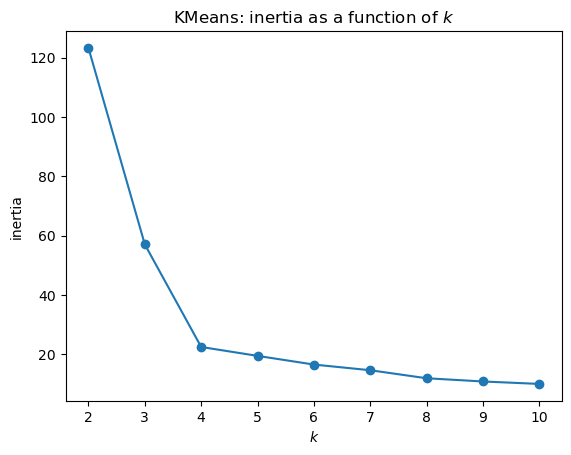

In [15]:
max_k = 10
ks = range(2, max_k+1)
best_inertias = [kmeans(X, k, best_only=True) for k in ks]

plt.plot(ks, best_inertias, 'o-')
plt.xticks(ks);
plt.xlabel('$k$')
plt.ylabel('inertia')
plt.title('KMeans: inertia as a function of $k$');

## Choosing $k$: Silhouette score

A second metric for evaluating a clustering is the **silhouette score**. Unlike inertia, silhouette also takes into account how close points are to their next nearest cluster and not just the cluster they belong to.

$a_i$ = average dissimilarity between observation $i$ and the other points in the cluster to which
$i$ belongs

$b_i$ = average dissimilarity between observation $i$ and the other points in the next closest
cluster to observation $i$

Let

$s_i = \frac{b_i - a_i}{\text{max}(a_i, b_i)}$

be the silhouette score for observation $i$.

High silhouette scores are better. Negative scores suggest that something is wrong: e.g., a point is placed in the wrong cluster or the observation itself is somehow strange.

SKLearn has the following methods in its `metrics` module:

[sklearn.metrics.**silhouette_score**(X, labels, *[, ...])](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) Compute the mean Silhouette Coefficient of all samples.

[sklearn.metrics.**silhouette_samples**(X, labels, *[, ...])](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) Compute the Silhouette Coefficient for each sample.

But to better understand this metric, let's create our own implementations of these 2 functions.

In [16]:
# get labels from init with minimum inertia from our previous kmeans run
labels = all_labels[:, all_inertias.argmin()]

# euclidean distance helper function
def euc_dist(x, y):
    return ((x - y)**2).sum(axis=1)**(1/2)

print('Euclidean distance from first observation to each centroid:')
euc_dist(X[0], get_centroids(X, labels))

Euclidean distance from first observation to each centroid:


array([ 4.96859693,  1.37952684,  6.31716132, 11.8227194 ])

Here we implement `silhouette_samples109` and `silhouette_score109` to mimic the SKLearn functions' behavior.

Again, you can test your understanding of by trying your own implementation without reference to the one below.

Hint:
* a helper function to calculate the silhouette score of a single observation might be useful. We'll call it `single_silhouette`
* don't forget your `get_centroids` and `euc_dist` helper functions

In [17]:
def single_silhouette(x_i, centroids):
    a_cluster, b_cluster = euc_dist(x_i, centroids).argsort()[:2]
    a_i = euc_dist(x_i, X[labels == a_cluster]).sum()/(X[labels == a_cluster].shape[0]-1)
    b_i = euc_dist(x_i, X[labels == b_cluster]).mean()
    return (b_i - a_i)/max(a_i, b_i)
    
def silhouette_samples109(X, labels):
    centroids = get_centroids(X, labels)
    return np.array([single_silhouette(x_i, centroids) for x_i in X])

def silhouette_score109(X, labels):
    return silhouette_samples109(X, labels).mean()

In [18]:
# assert you get the same results as sklearn
silhouette_score109(X, labels) == silhouette_score(X, labels)

True

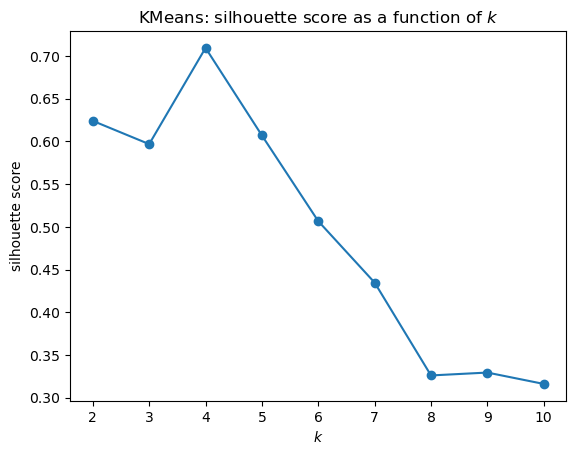

In [19]:
# average silhouette score for each candidate k
sil_scores = np.zeros_like(ks, dtype=float)
for i, k in enumerate(ks):
    all_labels, all_inertias = kmeans(X, k)
    best_labels = all_labels[:, np.argmin(all_inertias)]
    sil_scores[i] = silhouette_score(X, best_labels) 

plt.plot(ks, sil_scores, 'o-')
plt.xticks(ks);
plt.xlabel('$k$')
plt.ylabel('silhouette score')
plt.title('KMeans: silhouette score as a function of $k$');

**Q:** Which $k$ does the silhouette score suggest? Does it make sense? Is it in agreement with inertia?

## SKLearn's KMeans Implementations <a id='kmeans_sklearn'></a>

[back to table of contents](#top)

Of course, SKLearn has its own implementation of KMeans. 

[sklearn.cluster.**KMeans**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)(n_clusters=8, *, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

It uses the familiar `.fit()` and `.predict()` API you're used to from other SKLearn classes.\
`.fit()` learns the centroids and the cluster assignments ('labels') for each observation based on your choice of $k$ as well as other hyper parameters.\
`.predict()` gives class labels to new datapoints based on their distances to the learned centroids.

To try it out, let's use the [Old Faithful](https://en.wikipedia.org/wiki/Old_Faithful) dataset.

In [20]:
old_faithful = pd.read_csv('data/faithful.csv')
old_faithful

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
...,...,...
267,4.117,81
268,2.150,46
269,4.417,90
270,1.817,46


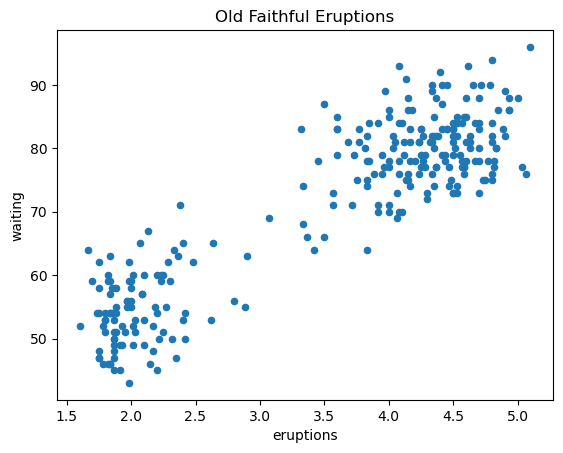

In [21]:
old_faithful.plot(kind='scatter',
               x='eruptions',
               y='waiting',
               title='Old Faithful Eruptions');

In [22]:
kmeans = KMeans(n_clusters=2, init='random', n_init=50, random_state=109)
kmeans.fit(old_faithful)

KMeans(init='random', n_clusters=2, n_init=50, random_state=109)

Now that we've 'fit' KMeans, we can look at various attributes of our clusters such as `cluster_centers_`, `labels_`, and `inertia_`.

In [23]:
print('cluster centers (centroids):')
display(kmeans.cluster_centers_)

cluster centers (centroids):


array([[ 2.09433   , 54.75      ],
       [ 4.29793023, 80.28488372]])

In [24]:
print('labels (first 10):')
display(kmeans.labels_[0:10])

labels (first 10):


array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1], dtype=int32)

In [25]:
print('inertia:')
display(kmeans.inertia_)

inertia:


8901.76872094721

Now let's visualize the resulting clusters.

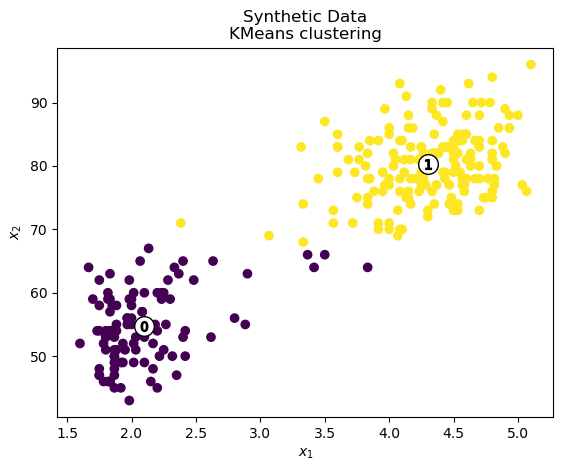

In [26]:
plt.scatter(old_faithful.values[:,0], old_faithful.values[:,1], c=kmeans.labels_)

centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

# add number to center markers
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker=f'${i}$', alpha=1,
                s=50, edgecolor='k')
plt.title('Synthetic Data\nKMeans clustering');
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

**Q:** Do you see any issues with this clustering? What may have gone wrong?

### SKLearn Pipelines (Aside)

We can use SKLearn's [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) to combine preprocessing and the clustering steps. 

In [21]:
kmeans_pipe = make_pipeline(StandardScaler(),
                            KMeans(n_clusters=2, init='random', n_init=50, random_state=109))
kmeans_pipe.fit(old_faithful)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans',
                 KMeans(init='random', n_clusters=2, n_init=50,
                        random_state=109))])

You can access an element of the pipeline by using the object's name in lowecase like a dictionary key.

In [22]:
kmeans_pipe['kmeans']

KMeans(init='random', n_clusters=2, n_init=50, random_state=109)

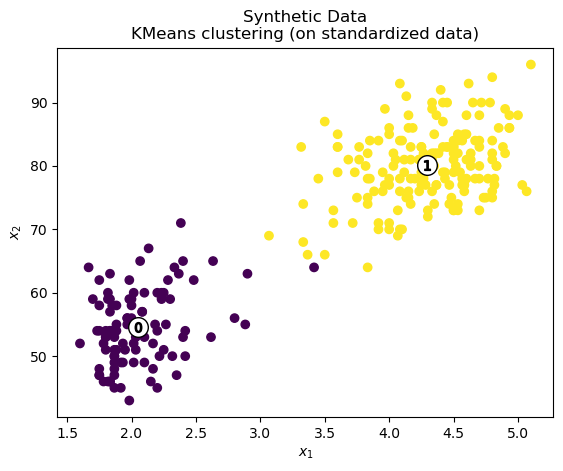

In [23]:
plt.scatter(old_faithful.values[:,0], old_faithful.values[:,1], c=kmeans_pipe['kmeans'].labels_)

centers = kmeans_pipe['kmeans'].cluster_centers_
# centers were calculated in scaled feature space
# so we need to inverse transform before plotting them
centers = kmeans_pipe['standardscaler'].inverse_transform(centers)
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

# add number to center markers
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker=f'${i}$', alpha=1,
                s=50, edgecolor='k')
plt.title('Synthetic Data\nKMeans clustering (on standardized data)');
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

We can also create a new datapoint and use `.predict()` on the KMeans object (inside the pipeline) to see which cluster it is assigned to.\
Note that you can always access the scaler object inside the pipeline if you need to do an **inverse transform of the centroids**. This is necessary if you want to plot the centroids in the *original* feature space because they were learned in the *scaled* space.

Let's see an example of these with our original, synthetic 'blob' data.

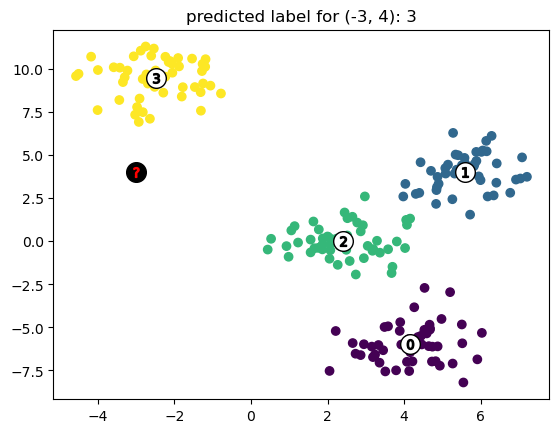

In [24]:
kmeans = KMeans(n_clusters=4, init='random', n_init=50, random_state=109).fit(X)

# plot the original data
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)

centers = kmeans.cluster_centers_

# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

# add number to center markers
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker=f'${i}$', alpha=1,
                s=50, edgecolor='k')

# plot new data point
new_data = [(-3, 4)]
plt.scatter(*new_data[0], marker='o',
            c='k',
            alpha=1, s=200, edgecolors='k')
plt.scatter(*new_data[0], marker=f'$?$', alpha=1,
            s=50, edgecolor='red')

# 'predict' cluster of new data points
predicted_label = kmeans.predict(new_data)

plt.title(f'predicted label for {new_data[0]}: {predicted_label[0]}');

## Selecting $k$ (continued)
### Gap Statistic <a id='gap'></a>

[back to table of contents](#top)

Our next metric for evaluating clusters, the Gap Statistic, which has the flavor of good, old-fashion hypothesis testing.

First, let's re-evaluate our KMeans clustering in terms of inertia using $k = 4$.

In [25]:
TRUE_K = 4
blob_data_inertia = KMeans(n_clusters=TRUE_K, n_init=25, random_state=109).fit(X).inertia_
print(f"KMeans Blob Data Inertial (k = {TRUE_K}): {blob_data_inertia:.2f}")

KMeans Blob Data Inertial (k = 4): 375.82


OK, but is this strong evidence for there *really* being 4 clusters?

###  Reference Datasets

To try and answer this question we can compare the above inertia to what we would get using the same clustering algorithm (and same $k$) on a *random*, 'reference' dataset.

One way [the original Gap statistic paper](https://hastie.su.domains/Papers/gap.pdf) suggests for producing a reference dataset is to sample points using a uniform distribution across the range observed for each feature in the original dataset.

In [26]:
N = X.shape[0]
x1 = np.random.uniform(X[:,0].min(), X[:,0].max(), size=N)
x2 = np.random.uniform(X[:,1].min(), X[:,1].max(), size=N)
X_ref = np.stack((x1,x2), axis=1)

We'll be creating multiple reference datasets so let's make this a function.

In [27]:
def unif_data_sample(X):
    N = X.shape[0]
    x1 = np.random.uniform(X[:,0].min(), X[:,0].max(), size=N)
    x2 = np.random.uniform(X[:,1].min(), X[:,1].max(), size=N)
    X_ref = np.stack((x1,x2), axis=1)
    return X_ref

We can now create a random reference dataset, fit KMeans, and compute the inertia of the resulting clustering.

In [28]:
TRUE_K = 4
X_ref = unif_data_sample(X)
km_sim = KMeans(n_clusters=TRUE_K, n_init=25, random_state=109).fit(X_ref)
km_sim.inertia_

2042.7082220128184

Not surprisingly, the inertia is much higher for the clustering of random data!

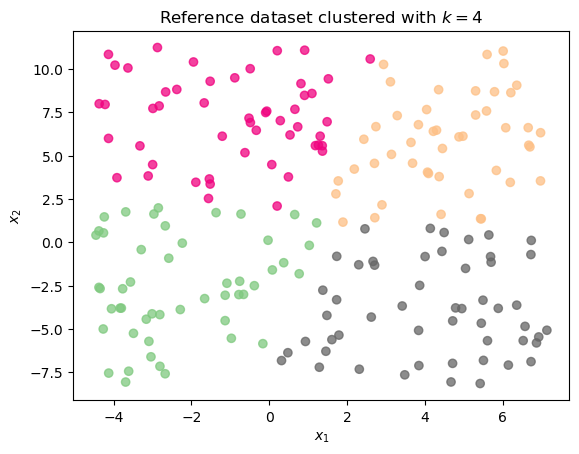

In [29]:
plt.scatter(*X_ref.T, alpha=0.75, c=km_sim.labels_, cmap='Accent')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title(f"Reference dataset clustered with $k=${TRUE_K}")
plt.grid(False);

### Calculating $Gap(K)$

The within cluster sum of square distances for a single cluster, $C_k$, is denoted $W(C_k)$.\
$W(C_k) = \sum\limits_{i,i^\prime\in C_k}\sum\limits_j^p (X_{ij}-X_{i^\prime j})^2$

The total within cluster sum of square distances across all $K$ clusters is denoted $T_K$.\
$T_K = \sum\limits^K W(C_k)$

We recall the total square distance from each point to its cluster mean is called the **inertia**.
$\text{inertia} = \sum\limits^K\sum\limits_{i\in C_k}\sum\limits_j^j(X_{ij}-\bar{X}_p)^2$

It turns out that the **total within cluster sum of square distances equals twice the total square distance from each point to its cluster mean**.\
$\sum\limits_{i,i^\prime\in C_k}\sum\limits_j^p (X_{ij}-X_{i^\prime j})^2 = 2\sum\limits^K\sum\limits_{i\in C_k}\sum\limits_j^j(X_{ij}-\bar{X}_p)^2$

That is,\
$T_K = 2\times \text{inertia}$

The Gap Statistic is defined to be:
$$Gap(K) = \frac{1}{B-1}\bigg(\sum\limits_{b=1}^B \log(T_k^{(b)})\bigg) - \log(T_k)$$

Where $B$ is the number of reference datasets used.

A fitted SKLearn KMeans object gives has inertia as an attribute. Because we get this 'for free' we'll calculate the Gap Statistic interms of inertia by means of its relationship to $T_K$ pointed out above.

The Gap Statistic in terms of inertia is then:
$$Gap(K) = \frac{1}{B-1}\bigg(\sum\limits_{b=1}^B \log(2\times\text{inertia}_{\text{ref}}^{(b)})\bigg) - \log(2\times\text{inertia}_{\text{data}})$$


### Inertias across many reference datasets

First, we calculate all the inertias, both for the simulated 'reference' datasets as well as the original data. This will be a bit more efficient as all the other operations involved in calculating $Gap(K)$, (multiplying by 2, taking the log, and taking a mean), can be 'vectorized' so they are performed all at once rather than many times in a loop.

One thing you'll notice is that this implementation is *slow*, so we'll a small number of reference datasets.

In [30]:
%%time
np.random.seed(109) # ensure reproducibility
B = 5 # num reference datasets
N = X.shape[0] # number of datapoints to generate per reference dataset
max_k = 10 # max number of clusters to evaluate
ks = range(1, max_k+1) # set of k values to evaluate
data_inertias = np.zeros(max_k) 
ref_inertias = np.zeros((B,max_k))

for k in ks:
    km = KMeans(n_clusters=k, n_init=25, random_state=109)
    data_inertias[k-1] = km.fit(X).inertia_
    for b in range(B):
        X_ref = unif_data_sample(X)
        ref_inertias[b, k-1] = km.fit(X_ref).inertia_

CPU times: user 6.46 s, sys: 17.5 ms, total: 6.47 s
Wall time: 1.63 s


With a distribution of reference inertias as well the data inertia for each $K$ we compute the vector of $Gap(K)$ values for all $K$:
$$Gap(K) = \frac{1}{B-1}\bigg(\sum\limits_{b=1}^B \log(2\times\text{inertia}_{\text{ref}}^{(b)})\bigg) - \log(2\times\text{inertia}_{\text{data}})$$


In [31]:
# gap statistic for each value of k
gap = np.sum(np.log(2*ref_inertias), axis=0)/(B-1) - np.log(2*data_inertias)

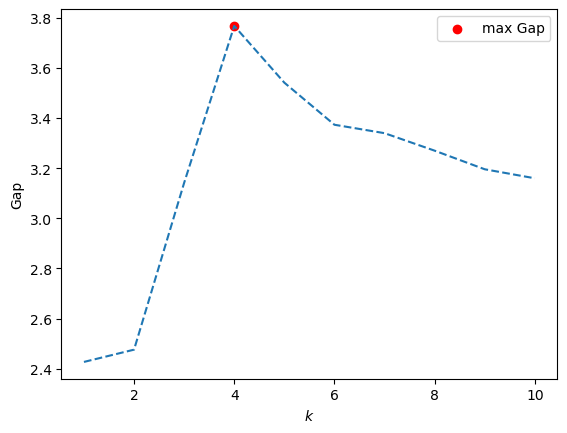

In [32]:
plt.plot(ks, gap, ls='--');
plt.scatter(ks[gap.argmax()], gap.max(),
            c='r', label='max Gap');
plt.ylabel('Gap')
plt.xlabel('$k$')
plt.legend();

### Alternative Methods for Choosing the Optimal $K$

#### Stopping aka 'slack' rule alternative

A later paper suggested a stopping rule for determining the optimal $K$ which takes into account our uncertainty regarding the referrence metrics.

First, find the standard deviation of the reference log within cluster sum of square distances for each $K$


$$sd(K) = \sqrt{\frac{1}{B}\sum\limits_{b=1}^B \big(\log(T_K^{(b)})-\bar{w}\big)^2} = \sqrt{\frac{1}{B}\sum\limits_{b=1}^B \big(\log(2\times\text{inertia}_{\text{ref}}^{(b)})-\bar{w}\big)^2}$$

Where $\bar{w}$ is simply the mean reference score.

$\bar{w}= \frac{1}{B}\sum\limits_{b=1}^B \log(T_K^{(b)}) = \frac{1}{B}\sum\limits_{b=1}^B \log(2\times\text{inertia}_{\text{ref}}^{(b)})$  

In [33]:
gap_sd = np.std(np.log(2*ref_inertias), axis=0)

The authors then *inflate* the standard deviation by a factor of $\sqrt{1+\frac{1}{B}}$

This inflated standard deviation is called $sk$

$s_K = sd(K)(\sqrt{1+\frac{1}{B}})$

In [34]:
gap_sk = gap_sd*np.sqrt(1+1/B)

For the stopping condition, we choose the lowest value of $K$ such that:\
$G(K) \geq Gap(K+1) - s_{K+1}$

We can simplify this rule by calculating a value `diff`

$\text{diff}_K = G(K) - Gap(K+1) + s_{K+1}$

In [35]:
diff = gap - (*gap[1:]-gap_sk[1:], np.nan)

Now the stoping rule amounts to finding the first value of $K$ for which $\text{diff}_K$ is non-negative.

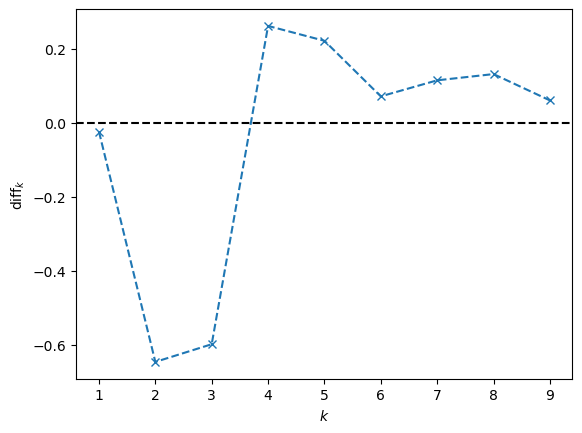

In [36]:
plt.plot(ks, diff, 'x--')
plt.axhline(0, c='k', ls='--');
plt.ylabel('$\\text{diff}_{k}$')
plt.xlabel('$k$');

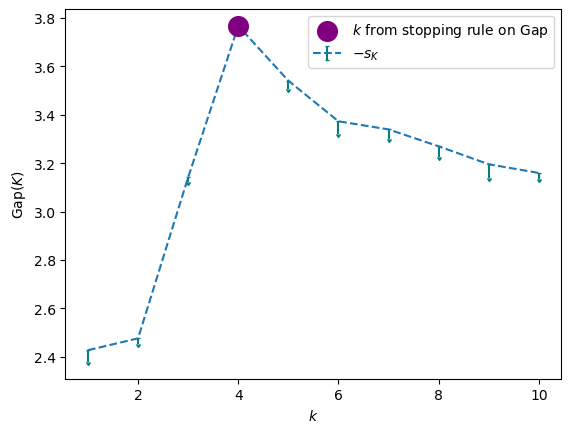

In [37]:
plt.errorbar(x=ks, y=gap, yerr=gap_sk,
             ls='--',
             ecolor='teal',
             capsize=1.5,
             uplims=True,
             label="$-s_K$")
stop_k = (diff >= 0).argmax()+1 
plt.scatter(stop_k, gap[stop_k-1],
            c='purple',
            s=200,
            zorder=3,
            label='$k$ from stopping rule on Gap')
plt.ylabel('Gap($K$)')
plt.xlabel('$k$')
plt.legend();

The $Gap(K)- s_K$ values are drawn on the plot above as error bars, but they are very small. We can zoom in to see them better.

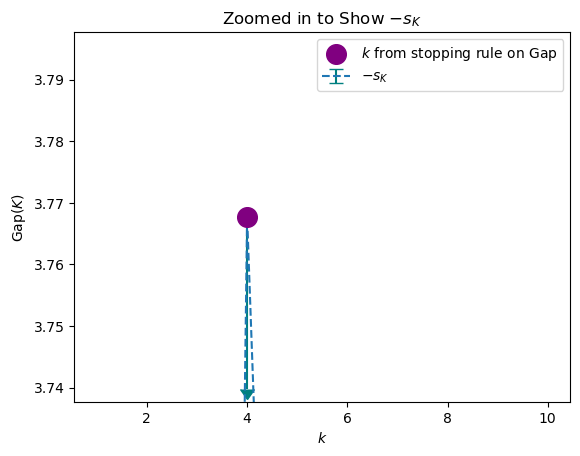

In [38]:
plt.errorbar(x=ks, y=gap, yerr=gap_sk,
             ls='--',
             ecolor='teal',
             capsize=5,
             uplims=True,
             label="$-s_K$");
stop_k = (diff >= 0).argmax()+1 
plt.scatter(stop_k, gap[stop_k-1],
            c='purple',
            s=200,
            zorder=3,
            label='$k$ from stopping rule on Gap')
plt.ylabel('Gap($K$)')
plt.xlabel('$k$')
plt.ylim(gap.max()-0.03, gap.max()+0.03)
plt.title("Zoomed in to Show $- s_K$")
plt.legend();

#### $Gap^*$

We can also perform all the same calculations except without the use of $\log$. This alternative was proposed in [a paper by Mohajer et al.](https://arxiv.org/pdf/1103.4767.pdf) and is called Gap* ("Gap star"). Gap* is more conservative, generally suggesting fewer clusters. The authors note that it doesn't perform well if there is significant overlap between clusters.

To observe this sensitivity, try playing with the `cluster_std` parameter of `make_blobs` at the beginning of the notebook.

In [39]:
gap_star = np.mean(2*ref_inertias, axis=0) - 2*data_inertias

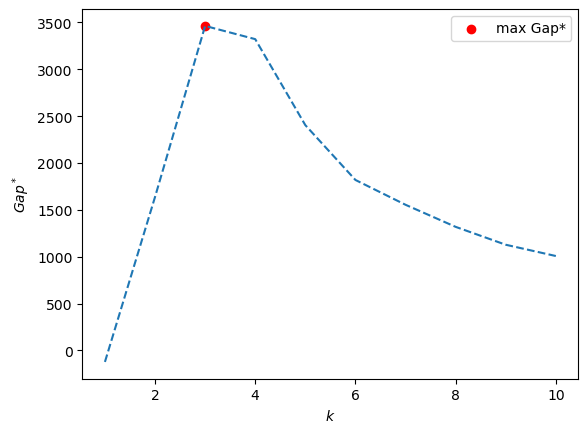

In [40]:
plt.plot(ks, gap_star, ls='--');
plt.scatter(ks[gap_star.argmax()], gap_star.max(),
            c='r', label='max Gap*');
plt.ylabel('$Gap^*$')
plt.xlabel('$k$')
plt.legend();

You could use the stopping condition with Gap* by calculating a $\text{diff}^*$, but this often results in $k$ values that are too low, so genreally the max Gap* is taken.

In [41]:
gap_star_sd = np.std(2*ref_inertias, axis=0)
gap_star_sk = gap_star_sd*np.sqrt(1+1/B)
diff_star = gap_star - (*gap_star[1:]-gap_star_sk[1:], np.nan)

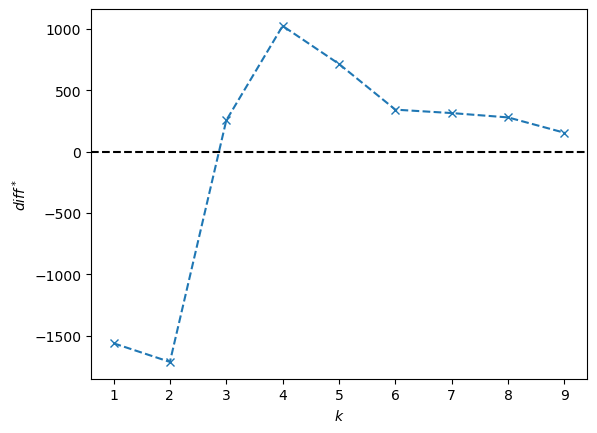

In [42]:
plt.plot(ks, diff_star, 'x--');
plt.axhline(0, c='k', ls='--')
plt.ylabel('$diff^*$')
plt.xlabel('$k$');

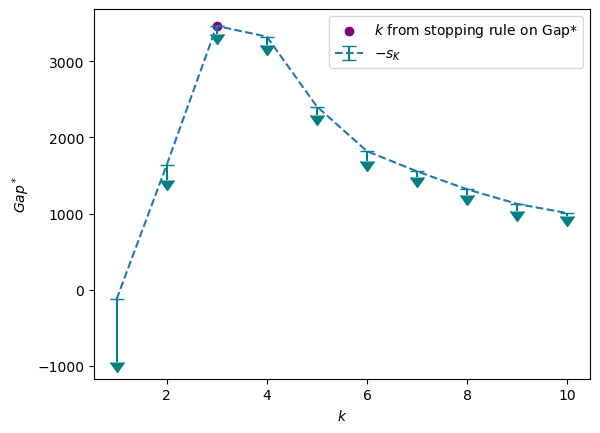

In [43]:
plt.errorbar(x=ks, y=gap_star, yerr=gap_star_sk,
             ls='--',
             ecolor='teal',
             capsize=5,
             uplims=True,
             label="$-s_K$");
stop_k = (diff_star >= 0).argmax()+1 
plt.scatter(stop_k, gap_star[stop_k-1],
            c='purple', label='$k$ from stopping rule on Gap*')
plt.ylabel('$Gap^*$')
plt.xlabel('$k$')
plt.legend();

**Gap Stat can be used with other clustering algorithm!**

As long as we defined a clustering function that:
* takes at minimum arguments $X$ (a data matrix) and $k$ (number of clusters) as arguments
* returns the resulting cluster centers and labels
Then we can use it with `OptimalK` to get a suggestion for a choice of $k$ with an arbitrary clustering algorithm.

You can also try changing the synthetic dataset at the beginning to be created from `make_moons` rathert than `make_blobs`.

How does this affect the suggested optimal $k$ across the various methods. What is it about the (1) the dataset and (2) the Gap Statistic that might account for how it performs in this scenario?


## DBSCAN <a id='dbscan'></a>

[A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise (Ester et al., 1996, KDD-96)](https://www2.cs.uh.edu/~ceick/7363/Papers/dbscan.pdf)

* can find any shape of clusters (compare to $k$-means)
* identifies observations that do not belong to clusters as outliers
* does not require specifying the number of clusters up-front (similar to hierarchical clustering)
* can be used for predicting cluster membership for new data

We'll use some synthetic data to demonstrate scenarios when DBSCAN outperforms other methods.

In [44]:
from sklearn.datasets import make_moons

In [45]:
X, y = make_moons(n_samples=750, noise=.05, random_state=109, )
X = StandardScaler().fit_transform(X)

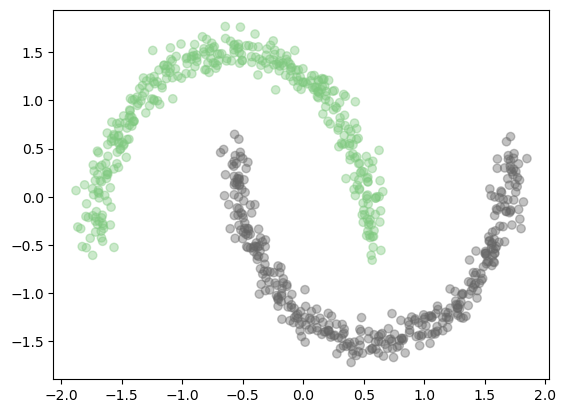

In [46]:
plt.scatter(*X.T, alpha=0.4, c=y, cmap=plt.cm.Accent);

In [47]:
from sklearn.cluster import DBSCAN

[sklearn.cluser.**DBSCAN**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

Let's compare the results of $k$-means and DBSCAN on this dataset.

💡Notice that we don't specify the number of clusters anywhere with DBSCAN

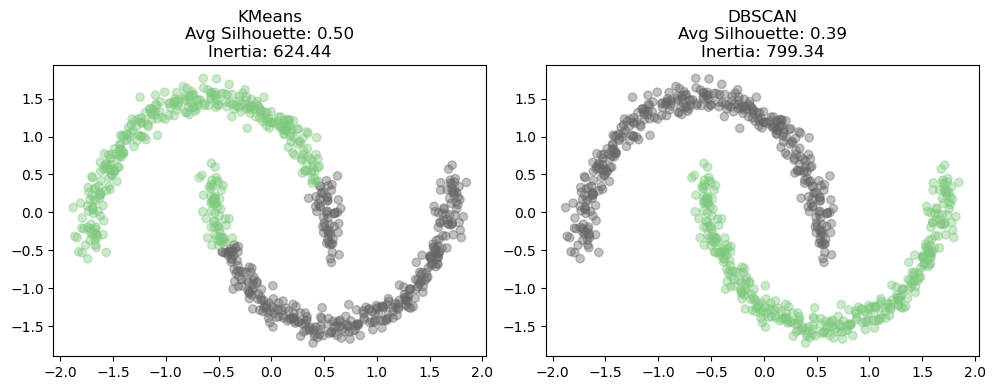

In [48]:
labels = {}
labels['KMeans'] = KMeans(n_clusters=2, n_init=50, random_state=109).fit(X).labels_
labels["DBSCAN"] = DBSCAN(eps=0.25, min_samples=10).fit(X).labels_

fig, axs = plt.subplots(1,2, figsize=(10,4))
for (title, cur_labels), ax in zip(labels.items(), axs):
    ax.scatter(*X.T, alpha=0.4, c=cur_labels, cmap=plt.cm.Accent)
    ax.set_title(f'{title}\n'+\
                 f'Avg Silhouette: {silhouette_score(X, cur_labels):.2f}\n'+\
                 f'Inertia: {inertia(X, get_centroids(X, cur_labels), cur_labels):.2f}')
plt.tight_layout()

In [49]:
pd.Series(labels['DBSCAN']).value_counts()

0    375
1    375
Name: count, dtype: int64

**Q:** How would you rank the clustering methods based on the **plots**?

**Q:** How would you rank the clustering methods based on the **metrics**?

**Q:** What do you conclude from this discrepancy?

**Q:** How does changing the `n_samples` and `noise` parameters of `make_moons` affect DBSCAN's results.

### Tuning DBSCAN's hyperparameters

In [50]:
from sklearn.neighbors import NearestNeighbors

The most important parameters of the `DBSCAN` constructor are:
* `eps` - radius of a 'neighborhood' around a point
* `min_points` - min number of points required to be within `eps` of a given point for it to be considered a core point.

<img src='img/DBSCAN1.png' width="150"></img>\
If `min_points` is $\leq 6$, then $x$ is a 'core point' in the above example.


<img src='img/DBSCAN2.png' width="200"></img>\
$x$ is a core point (at least `min_points` within `eps`), $y$ is a border point (at least 1 core point within `eps`), and $z$ is a noise point (no core point within `eps`).

Normally `min_points` is selected by a rule of thumb (~5-10) but can depend on your understanding of the density of your data.

To choose `eps` we look at where distances to the $N$-th neighbor among points undergo a big jump. Here $N$ would be set to our choice of `min_points`.

Sklearn's `NearestNeighbors` makes this easy for us.

In [51]:
min_points = 7
nn = NearestNeighbors(n_neighbors=min_points, metric='euclidean').fit(X)

In [52]:
distances, index = nn.kneighbors(X)

Distances to the nearest neighbors.

In [53]:
distances

array([[0.        , 0.01675665, 0.03333515, ..., 0.05668562, 0.06542121,
        0.09683897],
       [0.        , 0.01946948, 0.04926996, ..., 0.05329164, 0.05667208,
        0.06882907],
       [0.        , 0.07197934, 0.09550475, ..., 0.15708281, 0.15918063,
        0.16000972],
       ...,
       [0.        , 0.02893727, 0.03660713, ..., 0.05873774, 0.05889029,
        0.06664946],
       [0.        , 0.03070601, 0.03460691, ..., 0.06430804, 0.06460884,
        0.07073819],
       [0.        , 0.03542605, 0.04298871, ..., 0.05651504, 0.07012476,
        0.07021222]])

And indices of those neighbors.

In [54]:
index

array([[  0, 681, 477, ..., 741,  48, 427],
       [  1, 595, 722, ..., 461,  36, 737],
       [  2, 558, 219, ..., 710, 323, 235],
       ...,
       [747, 643, 238, ...,   9, 618, 335],
       [748, 313, 575, ..., 744, 550, 637],
       [749, 739, 153, ..., 585, 337, 511]])

For our purposes, we only need the distances.

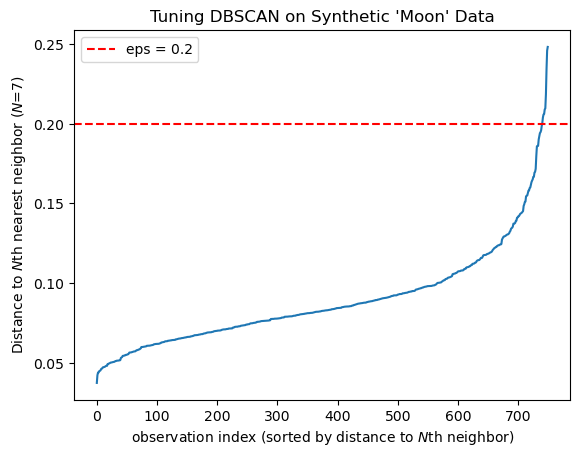

In [55]:
plt.plot(range(distances.shape[0]), np.sort(distances[:,-1]))
eps = 0.20
plt.axhline(eps, ls='--', c='r', label=f"eps = {eps}");
plt.xlabel('observation index (sorted by distance to $N$th neighbor)') 
plt.ylabel(f'Distance to $N$th nearest neighbor ($N$={min_points})')
plt.title("Tuning DBSCAN on Synthetic 'Moon' Data")
plt.legend();

We decide on an `eps` and instantiate and fit our DBSCAN object.

In [56]:
dbscan = DBSCAN(min_samples=min_points, eps=eps).fit(X)

Getting labels from the fitted DBSCAN object works the same as we saw for KMeans.

In [57]:
pd.Series(dbscan.labels_).value_counts()

0    375
1    375
Name: count, dtype: int64

### Visualizing the DBSCAN Algorithm

This page generates DBSCAN animations that can help improve our intuition as to what it is doing:
https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

### Recap: Clustering Penguins?

Let's do a quick recap by attempting to cluster the 'penguins' dataset provided in `seaborn`.

<img src='img/penguins.jpg' width='300'></img>

In [58]:
penguins_df = sns.load_dataset('penguins')
penguins_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Just a little preprocessing...

In [59]:
# drop rows with missing values
penguins_df = penguins_df.dropna().reset_index(drop=True)
X = penguins_df.copy()
# some categorical features need to be numerically encoded...
cat_calls = ['species', 'island', 'sex']
# ...but let's drop some to make the clustering more interesting!
to_drop = ['species', 'island', 'sex']
# get dummies for any categorical features we decided not to drop (if any)
dummy_cols = list(set(cat_calls) - set(to_drop))
X = pd.get_dummies(X.drop(to_drop, axis=1),
                       columns=dummy_cols, drop_first=True)
X = X.values

If we're going to be measuring similarity between observations based on some distance metric we should standardize the features so they are treated equally by the metric.

In [60]:
X_std = StandardScaler().fit_transform(X)

Can we tune **DBSCAN** to get a reasonable clustering on our penguins data?

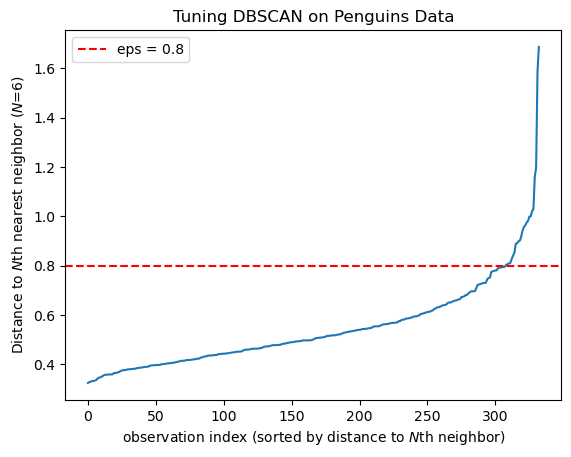

In [61]:
min_points = 6
eps = .8
nn = NearestNeighbors(n_neighbors=min_points, metric='euclidean').fit(X_std)
distances, index = nn.kneighbors(X_std)

plt.plot(range(distances.shape[0]), np.sort(distances[:,-1]))
plt.axhline(eps, ls='--', c='r', label=f"eps = {eps}");
plt.xlabel('observation index (sorted by distance to $N$th neighbor)') 
plt.ylabel(f'Distance to $N$th nearest neighbor ($N$={min_points})')
plt.title("Tuning DBSCAN on Penguins Data")
plt.legend();

In [62]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [63]:
dbscan = DBSCAN(eps=eps, min_samples=min_points).fit(X_std)

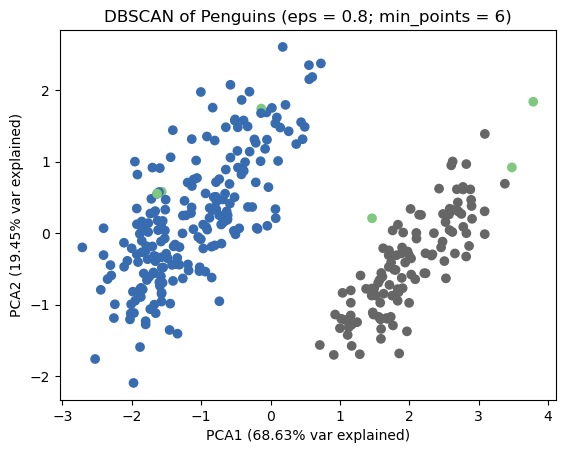

In [64]:
plt.scatter(*X_pca.T, c=dbscan.labels_, cmap=plt.cm.Accent);
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]:.2%} var explained)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]:.2%} var explained)")
plt.title(f'DBSCAN of Penguins (eps = {eps}; min_points = {min_points})');

**Q**: What do you think of this clustering? What might be an issue for DBSCAN with this data?

**Q**: How many clusters are shown in the plot above?

In [65]:
pd.Series(dbscan.labels_).value_counts()

 0    211
 1    116
-1      6
Name: count, dtype: int64

In fact, **$k$-means** actually does fairly well here.

In [66]:
# get inertias and silhouette scores for many ks
ks = range(1,21)
kms = {k: KMeans(n_clusters=k, n_init=25).fit(X_std) for k in ks}

inertias = [kms[k].inertia_ for k in ks]
sil_scores = [silhouette_score(X_std, kms[k].labels_) for k in ks[1:]]
sil_scores.insert(0,0)

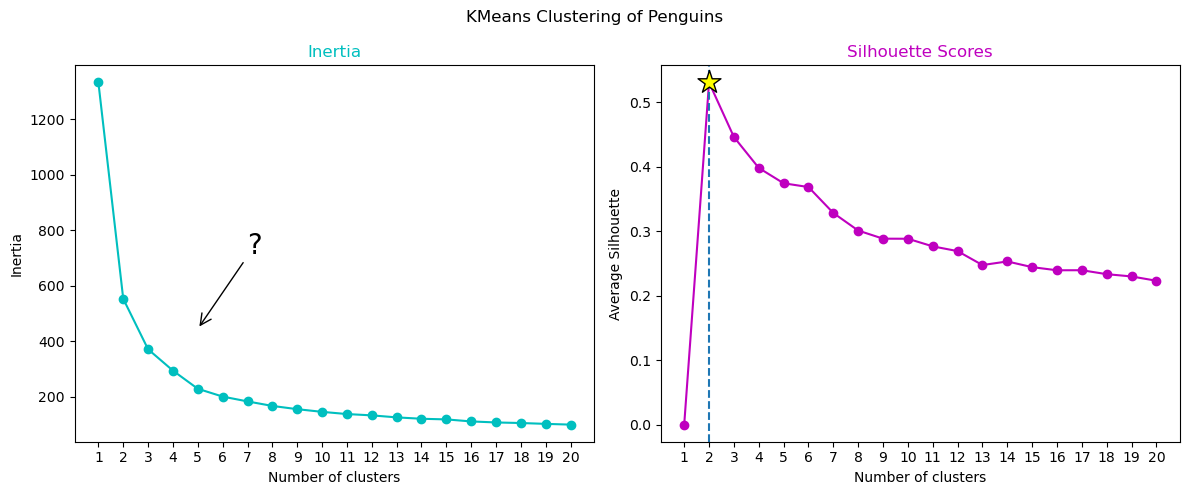

In [67]:
# plot cluster metrics as a function of k
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(ks, np.array(inertias), 'o-c')
axs[0].set_ylabel('Inertia')
axs[0].set_title('Inertia', color='c')
ylim = axs[0].get_ylim()
yrange = ylim[1] - ylim[0]
axs[0].annotate('?', (5, ylim[0]+yrange*.3), (7,ylim[0]+yrange*.5), fontsize=20, arrowprops=dict(arrowstyle='->'))

axs[1].plot(ks, np.array(sil_scores), 'o-m')
axs[1].set_ylabel('Average Silhouette')
axs[1].set_title('Silhouette Scores', color='m')
axs[1].axvline(ks[np.argmax(sil_scores)], ls='--')
axs[1].scatter(ks[np.argmax(sil_scores)], max(sil_scores),
               marker='*', s=300, zorder=4, c='yellow', edgecolor='k')
plt.suptitle(f'KMeans Clustering of Penguins')
for ax in axs:
    ax.set_xlabel('Number of clusters')
    ax.set_xticks(ks);
plt.tight_layout()

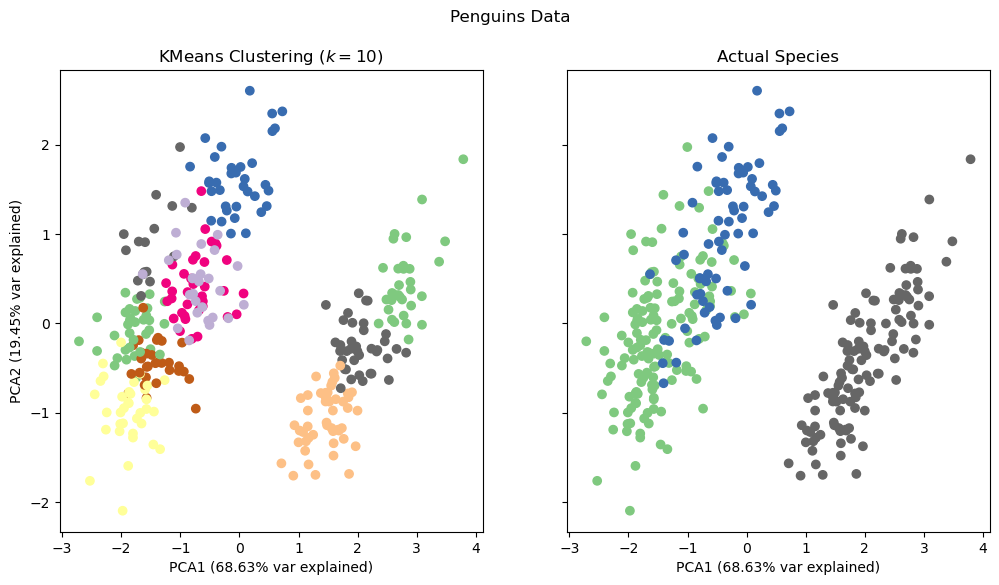

In [68]:
fig, axs = plt.subplots(1,2, figsize=(12,6), sharey=True)

# easy eay to map categorical strings to and from ints
labenc = LabelEncoder().fit(penguins_df.species)
axs[0].scatter(*X_pca.T, c=kms[k].labels_, cmap=plt.cm.Accent);
# axs[0].scatter(*X_pca.T, c=labenc.transform(penguins_df.species), cmap=plt.cm.Accent);
axs[0].set_xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]:.2%} var explained)")
axs[0].set_ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]:.2%} var explained)")
axs[0].set_title(f'KMeans Clustering ($k = ${k})');


# plot actual species
plt.scatter(*X_pca.T, c=labenc.transform(penguins_df.species), cmap=plt.cm.Accent);
axs[1].set_xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]:.2%} var explained)")
axs[1].set_title(f'Actual Species')
plt.suptitle('Penguins Data');

**The End** 🐧